In [81]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML

import torch
from torch.utils.data import Dataset, dataloader
import torch.nn.functional as F
from torchsummary import summary

import sys
sys.path.append('../src')
from model import UMI
from Animation import AnimatedScatter

### Data generation

In [3]:
def data_gen(n_cat,n_p):
    """Generate clusters of points around uniformly spaced points around origin in 2D

    Arguments:
        n_cat -- Number of categories
        n_p -- Number of points PER CATEGORY

    Returns:
        Array of cluster centers, array of all 2D datapoints, array of all corresponding labels to datapoints
    """
    n_tot = n_cat*n_p # Total number of datapoints
    centers = np.array([[np.cos(t*2*np.pi/n_cat),np.sin(t*2*np.pi/n_cat)] for t in range(n_cat)]) # Generate centers uniformly around the origin
    data = np.zeros((n_tot,2))
    labels = np.zeros(n_tot)
    for i in range(n_cat):
        scatter = np.random.normal(loc=centers[i],scale=.1, size=(n_p,2))
        data[i*n_p:(i+1)*n_p] = scatter
        labels[i*n_p:(i+1)*n_p] = i
    return centers,data,labels
    
n_categories = 4
n_p = 128 # points_per_category
centers,data,labels = data_gen(n_categories,n_p)

### Plotting of data

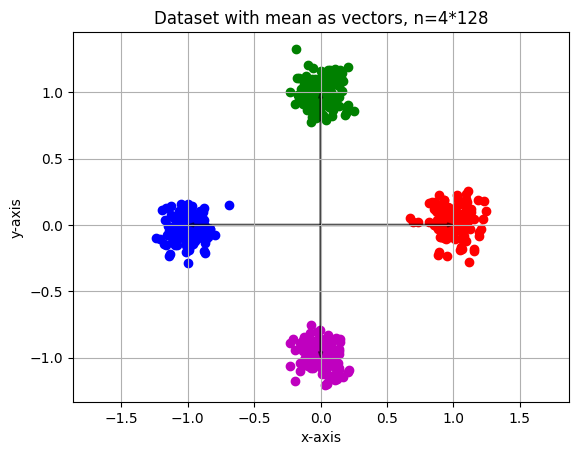

In [4]:
color_atlas = ["r","g","b","m","c","y","orange","brown","lime"]
colors = []
for i in range(n_categories):
    colors.append(color_atlas[i])

for col,center,i in zip(colors,centers,range(n_categories)):
    plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
    plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))

plt.title(f"Dataset with mean as vectors, n={n_categories}*{n_p}")
plt.axis("equal")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid("on")

### Putting data in PyTorch dataset

In [5]:
class ScatterData(Dataset):
    def __init__(self,points,labels,n_cat):
        self.x = torch.tensor(points).float()
        self.y = torch.tensor(labels).to(int)
        self.y = F.one_hot(self.y, num_classes=n_cat).double()
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [6]:
BATCH_SIZE = 32

training_data = ScatterData(data,labels,n_categories)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

### Create model

In [111]:
model = UMI(2,n_categories,L2=False)

In [112]:
model(torch.tensor([1.,0.]))

tensor([0.1231, 0.3438, 0.1558, 0.3772], grad_fn=<SoftmaxBackward0>)

In [113]:
summary(model,input_size=(1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]               8
Total params: 8
Trainable params: 8
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Training

In [114]:
w_his = []

In [115]:
def train(loader,model,n_epochs=5):
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
    return np.array(epochs), np.array(losses)

In [116]:
epoch_data, loss_data = train(training_loader,model,n_epochs=500)

16it [00:00, 1261.59it/s]0:00<?, ?it/s]
16it [00:00, 1778.10it/s]
16it [00:00, 1778.57it/s]
16it [00:00, 1777.39it/s]
16it [00:00, 1599.81it/s]
16it [00:00, 1453.39it/s]
16it [00:00, 1463.41it/s]
16it [00:00, 982.46it/s]
16it [00:00, 1432.33it/s]0:00<00:07, 69.61it/s]
16it [00:00, 1323.86it/s]
16it [00:00, 1333.77it/s]
16it [00:00, 1600.73it/s]
16it [00:00, 1766.16it/s]
16it [00:00, 1681.72it/s]
16it [00:00, 1351.77it/s]
16it [00:00, 1642.93it/s]
16it [00:00, 1410.95it/s]00:00<00:06, 70.08it/s]
16it [00:00, 1777.58it/s]
16it [00:00, 1733.45it/s]
16it [00:00, 1533.60it/s]
16it [00:00, 1522.61it/s]
16it [00:00, 1355.49it/s]
16it [00:00, 1404.33it/s]
16it [00:00, 1452.92it/s]
16it [00:00, 1427.82it/s]00:00<00:06, 70.87it/s]
16it [00:00, 1711.83it/s]
16it [00:00, 1599.51it/s]
16it [00:00, 1388.93it/s]
16it [00:00, 1777.86it/s]
16it [00:00, 1914.77it/s]
16it [00:00, 1778.38it/s]
16it [00:00, 1414.22it/s]
16it [00:00, 1592.33it/s]00:00<00:06, 71.83it/s]
16it [00:00, 1455.00it/s]
16it [00:00,

### Training results visualization

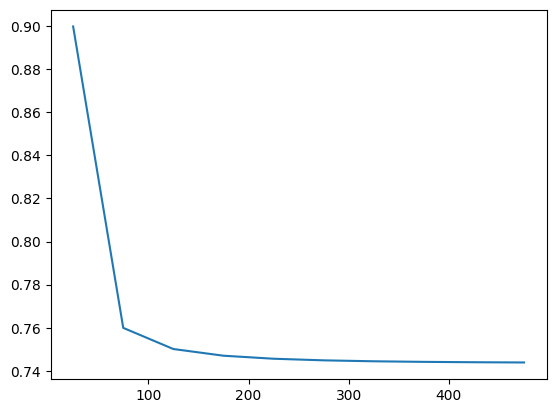

In [117]:
epoch_data_avgd = epoch_data.reshape(10,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(10,-1).mean(axis=1)
plt.plot(epoch_data_avgd,loss_data_avgd)
# plt.plot(epoch_data,loss_data)

### Testing

In [118]:
t_centers, test_data, test_labels = data_gen(n_categories,512)
test_set = ScatterData(test_data,test_labels,n_categories)

acc_tot = 0
for xs, ys in test_set:
    yhat = model(xs).argmax()
    ys = ys.argmax()
    if yhat == ys:
        acc_tot += 1

print(f'Accuracy: {acc_tot/len(test_set):.2f}')

Accuracy: 1.00


### Weights

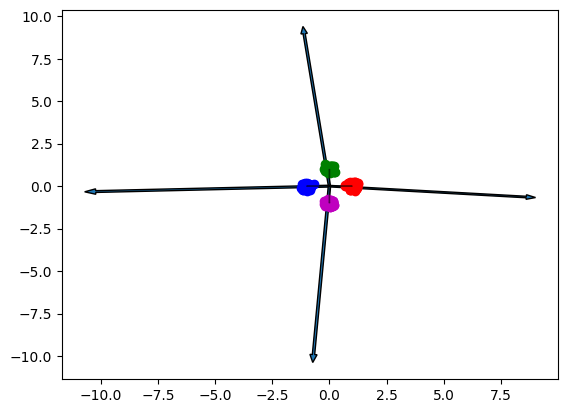

In [119]:
for param in model.parameters():
    w = param

w_np = w.detach().numpy()

for w in w_np:
    w_len = np.linalg.norm(w)
    width = 0.01*w_len
    plt.arrow(0,0,w[0],w[1],length_includes_head=True,width=width)

for col,center,i in zip(colors,centers,range(n_categories)):
    plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
    plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))

In [120]:
w_his = np.array(w_his)
print(w_his.reshape((500,8)).shape,loss_data[::16].shape)

(500, 8) (500,)


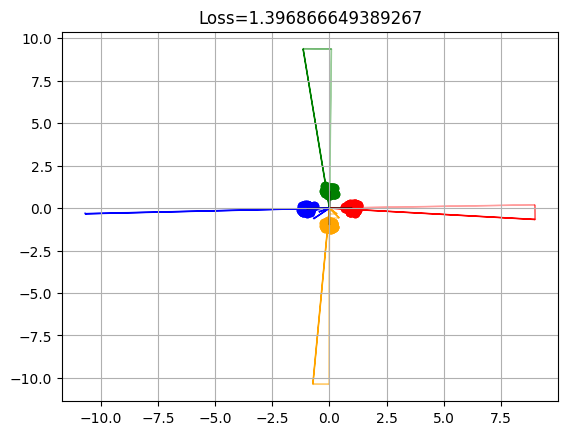

In [121]:
# animated_scatter = AnimatedScatter(data,w_his.reshape((500,2,4)),loss_data[::16])
animated_scatter = AnimatedScatter(data,w_his.transpose([0,2,1]),loss_data[::16])
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object